In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
import random
import math
from sklearn.metrics import roc_curve, roc_auc_score
import tensorflow as tf


## EDA

In [2]:
df = pd.read_csv('100k_a.csv', header=None)
df = df.rename(columns={0: 'user_id', 1: 'stream_id', 2: 'streamer_name', 3: 'start_time', 4: 'stop_time'})
df

,user_id,stream_id,streamer_name,start_time,stop_time
0,1,33842865744,mithrain,154,156
1,1,33846768288,alptv,166,169
2,1,33886469056,mithrain,587,588
3,1,33887624992,wtcn,589,591
4,1,33890145056,jrokezftw,591,594
...,...,...,...,...,...
3051728,100000,34167930576,mckytv,3582,3583
3051729,100000,34168288656,natehill,3582,3583
3051730,100000,34169594512,fortnite,3582,3584
3051731,100000,34180223072,highdistortion,3709,3711


In [3]:
df.isna().sum() # check for NAs

user_id          0
stream_id        0
streamer_name    0
start_time       0
stop_time        0
dtype: int64

In [4]:
df['user_id'].nunique(), df['stream_id'].nunique(), df['streamer_name'].nunique() # original checks

(100000, 739991, 162625)

In [5]:
# Start and stop times are provided as integers and represent periods of 10 minutes.
df['start_time'] = df['start_time'] * 10
df['stop_time'] = df['stop_time'] * 10

In [6]:
# convert minutes to hours
df['time_spent'] = df['stop_time'] - df['start_time']

In [7]:
# check for outliers in time_spent; those who watch greater than 8 hours, unrealistic for someone to actively be watching a stream for longer than 8 hours and more likely just left tab open
df[df['time_spent'] > 480]

,user_id,stream_id,streamer_name,start_time,stop_time,time_spent
7071,247,34317269936,failverde,50820,51370,550
18587,649,34071314928,dota2ruhub,25530,26040,510
22627,769,34103327360,elmiillor,28400,28950,550
33314,1133,34104883024,tfue,28560,29280,720
33316,1133,34115354272,ninja,29810,30360,550
...,...,...,...,...,...,...
3035821,99543,34219020832,zironicdk,41130,41620,490
3042010,99699,34157423888,mejash,34730,35240,510
3044264,99776,34057571888,dota2ruhub,23790,24350,560
3044380,99776,34374601376,dota2ruhub,56820,57360,540


In [8]:
# only keep those who have watched <= 8 hours
df = df[df['time_spent'] <= 480]
df

,user_id,stream_id,streamer_name,start_time,stop_time,time_spent
0,1,33842865744,mithrain,1540,1560,20
1,1,33846768288,alptv,1660,1690,30
2,1,33886469056,mithrain,5870,5880,10
3,1,33887624992,wtcn,5890,5910,20
4,1,33890145056,jrokezftw,5910,5940,30
...,...,...,...,...,...,...
3051728,100000,34167930576,mckytv,35820,35830,10
3051729,100000,34168288656,natehill,35820,35830,10
3051730,100000,34169594512,fortnite,35820,35840,20
3051731,100000,34180223072,highdistortion,37090,37110,20


In [9]:
df['time_spent'].value_counts()

time_spent
10     1559891
20      498252
30      263958
40      168944
50      115769
60       85323
70       64238
80       49751
90       40007
100      32180
110      26825
120      22509
130      18312
140      15173
150      12759
160      10884
170       9396
180       8149
190       6876
200       5834
210       4922
220       4384
230       3832
240       3292
250       2849
260       2276
270       1983
280       1740
290       1430
300       1308
310       1084
320        996
330        823
340        737
350        688
360        565
370        468
380        426
390        372
400        296
420        276
410        263
430        223
440        207
450        168
460        136
470        134
480         94
Name: count, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3051002 entries, 0 to 3051732
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   user_id        int64 
 1   stream_id      int64 
 2   streamer_name  object
 3   start_time     int64 
 4   stop_time      int64 
 5   time_spent     int64 
dtypes: int64(5), object(1)
memory usage: 162.9+ MB


In [11]:
df.describe()

,user_id,stream_id,start_time,stop_time,time_spent
count,3.051002e+06,3.051002e+06,3.051002e+06,3.051002e+06,3.051002e+06
mean,5.032247e+04,3.413001e+10,3.145919e+04,3.149048e+04,3.129228e+01
std,2.889483e+04,1.682299e+08,1.772582e+04,1.772713e+04,4.175118e+01
min,1.000000e+00,3.380153e+10,0.000000e+00,1.000000e+01,1.000000e+01
25%,2.528400e+04,3.398877e+10,1.617000e+04,1.620000e+04,1.000000e+01
50%,5.029800e+04,3.413068e+10,3.174000e+04,3.178000e+04,1.000000e+01
75%,7.545200e+04,3.427399e+10,4.676000e+04,4.679000e+04,3.000000e+01
max,1.000000e+05,3.441642e+10,6.147000e+04,6.148000e+04,4.800000e+02


In [12]:
# number of streamer_names and number of stream_ids are different, suggesting that each streamer_name maps to multiple stream_ids, use streamer_name as item
df['user_id'].nunique(), df['stream_id'].nunique(), df['streamer_name'].nunique() 

(100000, 739972, 162624)

In [13]:
# drop irrelevant features:
df = df.drop(['stream_id','start_time','stop_time'], axis=1)
df

,user_id,streamer_name,time_spent
0,1,mithrain,20
1,1,alptv,30
2,1,mithrain,10
3,1,wtcn,20
4,1,jrokezftw,30
...,...,...,...
3051728,100000,mckytv,10
3051729,100000,natehill,10
3051730,100000,fortnite,20
3051731,100000,highdistortion,20


/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


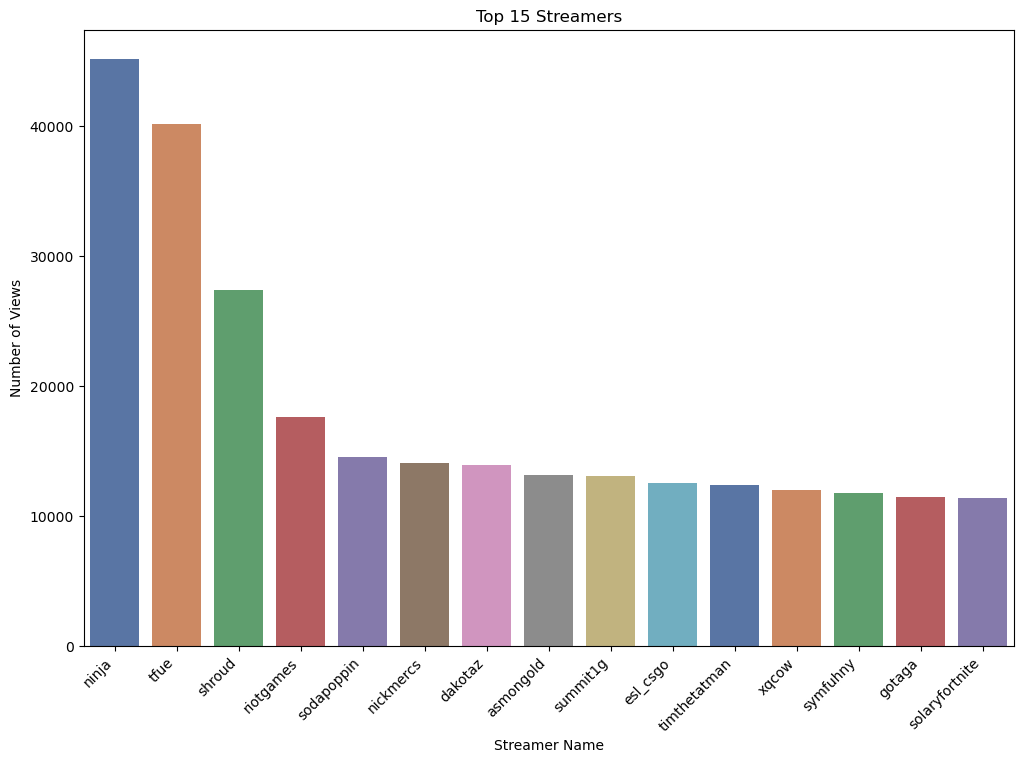

In [14]:
# Most popular streamers
top_streamers = df['streamer_name'].value_counts().nlargest(15)

# Plotting with Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x=top_streamers.index, y=top_streamers.values, palette='deep')
plt.title('Top 15 Streamers')
plt.xlabel('Streamer Name')
plt.ylabel('Number of Views')
plt.xticks(rotation=45, ha='right')
plt.show()


/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Number of Unique Streamers')

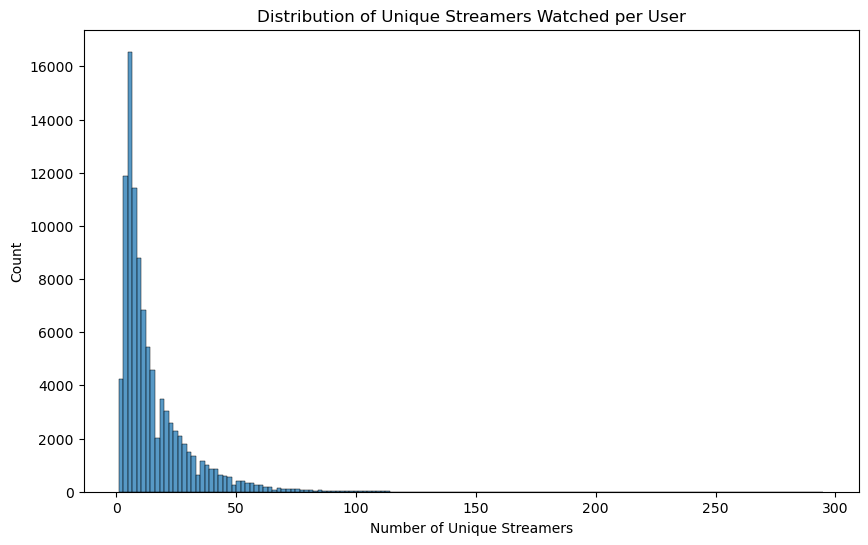

In [15]:
# Distribution of number of unique streamers watched by user
unique_streamers_per_user = df.groupby('user_id')['streamer_name'].nunique()

plt.figure(figsize=(10, 6))
sns.histplot(unique_streamers_per_user, bins=156)
plt.title('Distribution of Unique Streamers Watched per User')
plt.xlabel('Number of Unique Streamers')

In [16]:
unique_streamers_per_user.nunique(), unique_streamers_per_user.value_counts().sort_values(ascending=False)

(156,
 streamer_name
 5      9157
 6      7394
 4      7141
 7      6206
 8      5216
        ... 
 148       1
 145       1
 131       1
 197       1
 184       1
 Name: count, Length: 156, dtype: int64)

/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Number of Times Watched')

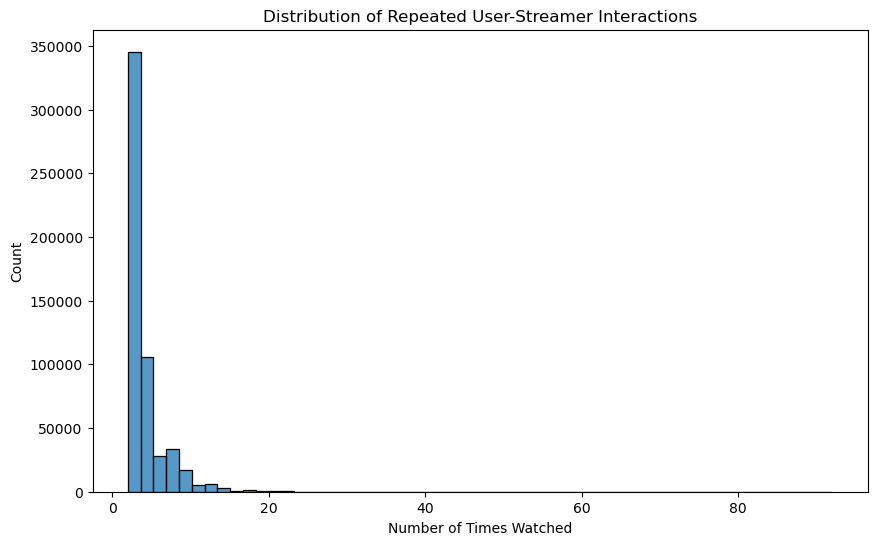

In [17]:
# Distribution of repeated user streamer interactions
user_streamer_pairs_counts = df.groupby(['user_id', 'streamer_name']).size().reset_index(name='watch_count')

# filter for repeated watches
rewatched_pairs = user_streamer_pairs_counts[user_streamer_pairs_counts['watch_count'] > 1]

plt.figure(figsize=(10, 6))
sns.histplot(rewatched_pairs['watch_count'], bins=55)
plt.title('Distribution of Repeated User-Streamer Interactions')
plt.xlabel('Number of Times Watched')

In [18]:
rewatched_pairs['watch_count'].nunique(), rewatched_pairs['watch_count'].value_counts().sort_values(ascending=False)

(55,
 watch_count
 2     234196
 3     111210
 4      64250
 5      41576
 6      27919
 7      19368
 8      13904
 9       9912
 10      7109
 11      5241
 12      3726
 13      2635
 14      1858
 15      1341
 16       952
 17       644
 18       480
 19       341
 20       257
 21       185
 22       148
 23       113
 24        75
 25        68
 26        55
 27        41
 28        39
 31        24
 29        24
 30        21
 33        12
 32        11
 37        10
 36         7
 34         6
 35         6
 39         6
 38         6
 40         5
 41         5
 47         4
 42         3
 44         3
 62         2
 50         2
 52         2
 63         2
 45         2
 78         1
 48         1
 92         1
 82         1
 90         1
 59         1
 61         1
 Name: count, dtype: int64)

/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Time Spent (minutes)')

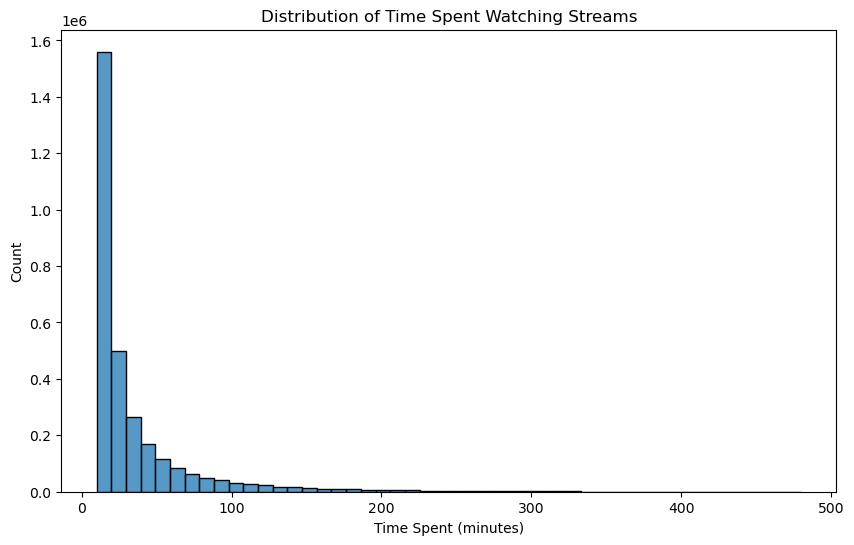

In [19]:
# distribution of time spent
plt.figure(figsize=(10, 6))
sns.histplot(df['time_spent'], bins=48)
plt.title('Distribution of Time Spent Watching Streams')
plt.xlabel('Time Spent (minutes)')

In [20]:
df['time_spent'].nunique(), df['time_spent'].value_counts()

(48,
 time_spent
 10     1559891
 20      498252
 30      263958
 40      168944
 50      115769
 60       85323
 70       64238
 80       49751
 90       40007
 100      32180
 110      26825
 120      22509
 130      18312
 140      15173
 150      12759
 160      10884
 170       9396
 180       8149
 190       6876
 200       5834
 210       4922
 220       4384
 230       3832
 240       3292
 250       2849
 260       2276
 270       1983
 280       1740
 290       1430
 300       1308
 310       1084
 320        996
 330        823
 340        737
 350        688
 360        565
 370        468
 380        426
 390        372
 400        296
 420        276
 410        263
 430        223
 440        207
 450        168
 460        136
 470        134
 480         94
 Name: count, dtype: int64)

/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprec

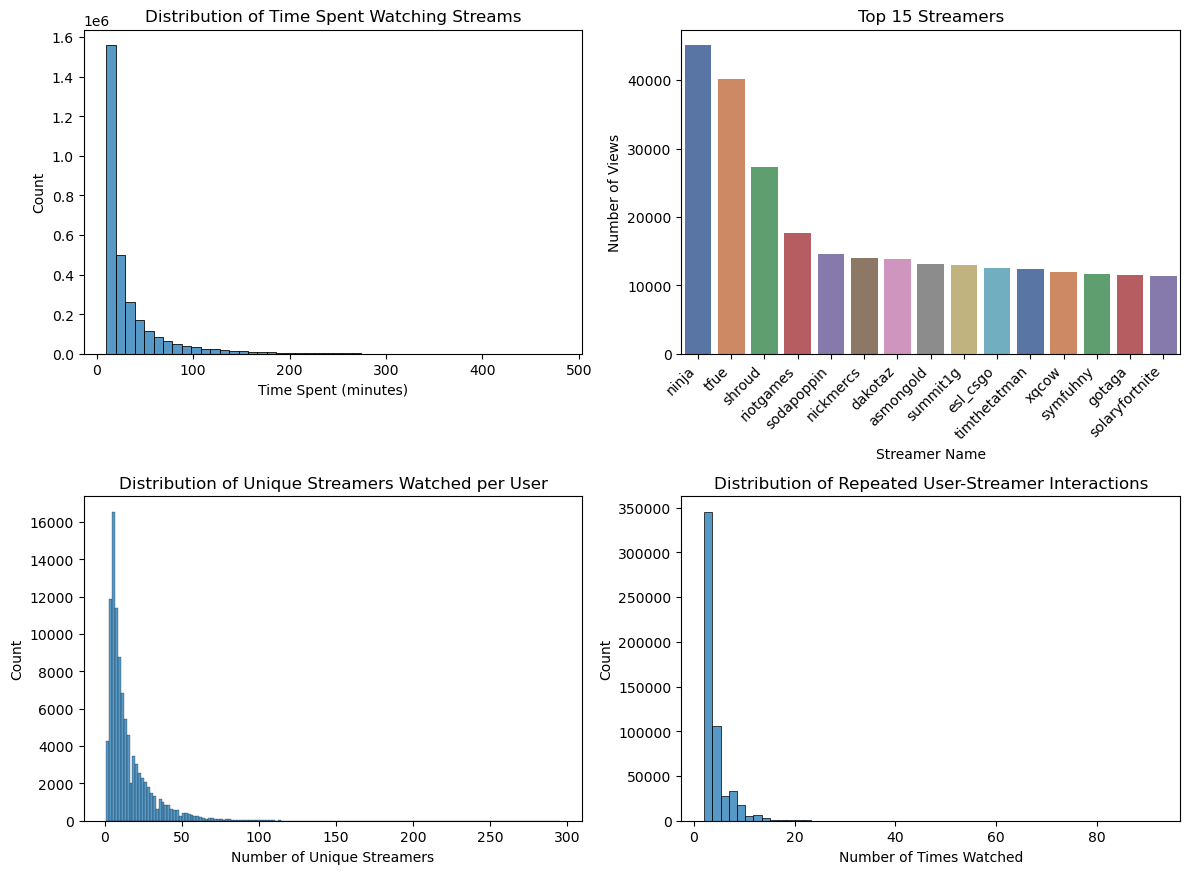

In [21]:
# Top left: Distribution of time spent
plt.figure(figsize=(12, 9))

plt.subplot(2, 2, 1)
sns.histplot(df['time_spent'], bins=48)
plt.title('Distribution of Time Spent Watching Streams')
plt.xlabel('Time Spent (minutes)')

# Top right: Top 15 most popular streamers
plt.subplot(2, 2, 2)
sns.barplot(x=top_streamers.index, y=top_streamers.values, palette='deep')
plt.title('Top 15 Streamers')
plt.xlabel('Streamer Name')
plt.ylabel('Number of Views')
plt.xticks(rotation=45, ha='right')

# Bottom left: Distribution of number of unique streamers watched by user
plt.subplot(2, 2, 3)
sns.histplot(unique_streamers_per_user, bins=156)
plt.title('Distribution of Unique Streamers Watched per User')
plt.xlabel('Number of Unique Streamers')

# Bottom right: Distribution of repeated user streamer interactions
plt.subplot(2, 2, 4)
sns.histplot(rewatched_pairs['watch_count'], bins=55)
plt.title('Distribution of Repeated User-Streamer Interactions')
plt.xlabel('Number of Times Watched')

# Adjust layout
plt.tight_layout()

#plt.savefig('eda_figs.png', dpi=500)

In [22]:
# shuffle dataframe
df = df.sample(frac=1, random_state=42)  
df

,user_id,streamer_name,time_spent
559707,18494,forsen,40
81219,2723,callofduty,10
301537,10197,elraenn,10
986344,32688,nubkeks,60
1660926,54764,mrbboy45,10
...,...,...,...
1693123,55868,wazztv_,10
2356878,77705,lol_madlife,70
2229595,73485,italiand0g,40
2768969,91071,gsl,50


In [23]:
# convert df to list of json
data = df.to_dict(orient='records')

In [24]:
# Build basic data structures for WHOLE dataset:
uniqueStreamers = set() 
watchedSet = set()
streamerPerUser = defaultdict(set)
usersPerStreamer = defaultdict(set)
streamerViews = defaultdict(int)
interactionCount = defaultdict(int)
timeDict = {}
userIDs,streamerIDs = {},{}

for d in data:
    user = d['user_id']
    streamer = d['streamer_name']
    if not user in userIDs: userIDs[user] = len(userIDs)
    if not streamer in streamerIDs: streamerIDs[streamer] = len(streamerIDs)
    uniqueStreamers.add(streamer)
    watchedSet.add((user,streamer))
    streamerPerUser[user].add(streamer)
    usersPerStreamer[streamer].add(user)
    streamerViews[streamer] += 1
    interactionCount[(user,streamer)] += 1
    timeDict[(user,streamer)] = d['time_spent']

# Data Preparation

In [25]:
# Split into training, validation, testing
train, temp = train_test_split(data, test_size=0.3, random_state=123)
valid, test = train_test_split(temp, test_size=0.5, random_state=123)

In [26]:
len(data), len(temp), len(valid), len(test)

(3051002, 915301, 457650, 457651)

In [27]:
len(data), len(train) + len(valid) + len(test)

(3051002, 3051002)

In [28]:
## Generate negative samples for validation set
watchedValid = set()
for d in valid:
    watchedValid.add((d['user_id'],d['streamer_name']))

notWatchedValid = set()
for d in valid:
    u = d['user_id']
    s = random.choice(list(uniqueStreamers))
    while (u,s) in watchedSet or (u,s) in notWatchedValid:
        s = random.choice(list(uniqueStreamers))
    notWatchedValid.add((u,s))

In [29]:
## Generate negative samples for testing set
watchedTest = set()
for d in test:
    watchedTest.add((d['user_id'],d['streamer_name']))

notWatchedTest = set()
for d in test:
    u = d['user_id']
    s = random.choice(list(uniqueStreamers))
    while (u,s) in watchedSet or (u,s) in notWatchedTest:
        s = random.choice(list(uniqueStreamers))
    notWatchedTest.add((u,s))

In [30]:
# Build basic data structures for TRAINING dataset:
streamerPerUserTrain = defaultdict(set)
usersPerStreamerTrain = defaultdict(set)
streamerViewsTrain = defaultdict(int)
interactionCountTrain = defaultdict(int)
timeDictTrain = {}

for d in train:
    user = d['user_id']
    streamer = d['streamer_name']
    streamerPerUserTrain[user].add(streamer)
    usersPerStreamerTrain[streamer].add(user)
    streamerViewsTrain[streamer] += 1
    interactionCountTrain[(user,streamer)] += 1
    timeDictTrain[(user,streamer)] = d['time_spent']

# streamerPerUser = defaultdict(set)
# usersPerStreamer = defaultdict(set)
# streamerPopularity = defaultdict(int)
# timeDict = {}

# for index, row in train.iterrows():
#     user = row['user_id']
#     streamer = row['streamer name']
#     time = row['time spent']
#     streamerPerUser[user].add(streamer)
#     usersPerStreamer[streamer].add(user)
#     streamerPopularity[streamer] += 1
#     timeDict[(user,streamer)] = time

In [31]:
# def plot_roc_curve(true_y, y_prob, title):
#     fpr, tpr, thresholds = roc_curve(true_y, y_prob)
#     auc = round(roc_auc_score(true_y, y_prob), 4)
#     plt.plot(fpr, tpr, label=f'{title} AUC = {auc:.2f}')
#     plt.legend()
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')

In [32]:
yTest = [1 for _ in watchedTest] +[0 for _ in notWatchedTest] # for auc

# Models

### Popularity

In [33]:
# Popularity accuracy (VALIDATION DATA)
correct = 0
p1 = 0

for (label,sample) in [(1, watchedValid), (0, notWatchedValid)]: 
    for (u,s) in sample:
        pred = 0
        if len(usersPerStreamerTrain[s]) > 10: 
            pred = 1
            p1+= 1
        if pred == label:
            correct += 1

pop_accValid = correct / (len(watchedValid) + len(notWatchedValid)) 
pop_accValid , p1

(0.8764128412841284, 339915)

In [34]:
# Popularity accuracy (TEST DATA)
correct = 0
p1 = 0
popLabels = []
for (label,sample) in [(1, watchedTest), (0, notWatchedTest)]: 
    for (u,s) in sample:
        pred = 0
        if len(usersPerStreamerTrain[s]) > 10: 
            pred = 1
            p1+= 1
        if pred == label:
            correct += 1
        popLabels.append(pred)
        
pop_accTest = correct / (len(watchedValid) + len(notWatchedValid)) 
pop_accTest , p1

(0.8769300930093009, 339713)

In [65]:
# Popularity AUC
pop_AUC = round(roc_auc_score(yTest, popLabels), 4)
pop_AUC

0.8716

### Jaccard + Popularity

In [36]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

In [37]:
# # Jaccard only
# correct = 0
# p1 = 0
# jaccardLabels = []

# for (label,sample) in [(1, watchedValid), (0, notWatchedValid)]: 
#     for (u,s) in sample:
#         maxSim = float('-inf')
#         users = usersPerStreamerTrain[s]
#         pred = 0

#         for s2 in streamerPerUserTrain[u]:
#             sim = Jaccard(users,usersPerStreamerTrain[s2])
#             if sim == 1:
#                 maxSim = sim
#                 break
#             if sim > maxSim:
#                 maxSim = sim
#         if maxSim > 0.058:
#             pred = 1
#             p1 += 1
#         if maxSim == float('-inf'):
#             jaccardLabels.append(0)
#             continue
#         if pred == label:
#             correct += 1
#         jaccardLabels.append(pred)
        
# correct / (len(watchedValid) + len(notWatchedValid)) , p1

In [38]:
# # Jaccard + Popularity
# correct = 0
# p1 = 0
# predLabels = []
# for (label,sample) in [(1, watchedValid), (0, notWatchedValid)]: 
#     for (u,s) in sample:
#         maxSim = float('-inf')
#         users = usersPerStreamerTrain[s]
#         pred = 0

#         # cold-start user, just consider popularity of stream
#         if u not in streamerPerUserTrain:
#             if len(usersPerStreamerTrain[s]) > 10:
#                 pred = 1
#                 p1 += 1
#             predLabels.append(pred)
#         # user has been seen before
#         else:
#             for s2 in streamerPerUserTrain[u]:
#                 sim = Jaccard(users,usersPerStreamerTrain[s2])
#                 if sim == 1:
#                     maxSim = sim
#                     break
#                 if sim > maxSim:
#                     maxSim = sim
#             if maxSim > 0.058 or len(usersPerStreamerTrain[s]) > 10:
#                 pred = 1
#                 p1 += 1
#         if maxSim == float('-inf') and pred == 0:
#             predLabels.append(0)
#             continue
#         if pred == label:
#             correct += 1
#         predLabels.append(pred)

# correct / (len(watchedValid) + len(notWatchedValid)) , p1

In [39]:
# Jaccard + Popularity accuracy (VALIDATION DATA)
correct = 0
p1 = 0
for (label,sample) in [(1, watchedValid), (0, notWatchedValid)]: 
    for (u,s) in sample:
        maxSim = float('-inf')
        users = usersPerStreamerTrain[s]
        pred = 0

        # cold-start user, just consider popularity of stream
        if u not in streamerPerUserTrain:
            if len(usersPerStreamerTrain[s]) > 10:
                pred = 1
                p1 += 1
        # user has been seen before
        else:
            for s2 in streamerPerUserTrain[u]:
                sim = Jaccard(users,usersPerStreamerTrain[s2])
                if sim == 1:
                    maxSim = sim
                    break
                if sim > maxSim:
                    maxSim = sim
            if maxSim > 0.058 or len(usersPerStreamerTrain[s]) > 10:
                pred = 1
                p1 += 1
        
        if pred == label:
            correct += 1

jaccardPop_accValid = correct / (len(watchedValid) + len(notWatchedValid)) 
jaccardPop_accValid , p1

(0.9191491149114911, 376471)

In [40]:
# Jaccard + Popularity accuracy (TEST DATA)
correct = 0
p1 = 0
jaccardPopLabels = []

for (label,sample) in [(1, watchedTest), (0, notWatchedTest)]: 
    for (u,s) in sample:
        maxSim = float('-inf')
        users = usersPerStreamerTrain[s]
        pred = 0

        # cold-start user, just consider popularity of stream
        if u not in streamerPerUserTrain:
            if len(usersPerStreamerTrain[s]) > 10:
                pred = 1
                p1 += 1
        # user has been seen before
        else:
            for s2 in streamerPerUserTrain[u]:
                sim = Jaccard(users,usersPerStreamerTrain[s2])
                if sim == 1:
                    maxSim = sim
                    break
                if sim > maxSim:
                    maxSim = sim
            if maxSim > 0.058 or len(usersPerStreamerTrain[s]) > 10:
                pred = 1
                p1 += 1
        
        if pred == label:
            correct += 1
        jaccardPopLabels.append(pred)

jaccardPop_accTest = correct / (len(watchedTest) + len(notWatchedTest)) 
jaccardPop_accTest , p1

(0.9192201459885557, 375762)

In [66]:
# JaccardPop AUC
jaccardPop_AUC = round(roc_auc_score(yTest, jaccardPopLabels), 4)
jaccardPop_AUC

0.9185

### Cosine

In [42]:
def CosineSet(s1, s2):
    # Not a proper implementation, operates on sets so correct for interactions only
    numer = len(s1.intersection(s2))
    denom = math.sqrt(len(s1)) * math.sqrt(len(s2))
    if denom == 0:
        return 0
    return numer / denom

In [43]:
# # Cosine Only
# correct = 0
# p1 = 0
# cosineLabels = []
# for (label,sample) in [(1, watchedValid), (0, notWatchedValid)]: 
#     for (u,s) in sample:
#         maxSim = float('-inf')
#         users = usersPerStreamerTrain[s]
#         pred = 0

#         for s2 in streamerPerUserTrain[u]:
#             sim = CosineSet(users,usersPerStreamerTrain[s2])
#             if sim > maxSim:
#                 maxSim = sim
#             if maxSim >= 0.9999:
#                 break
#         if maxSim > 0.1:
#             pred = 1
#             p1 += 1
#         if maxSim == float('-inf'):
#             cosineLabels.append(pred)
#             continue
#         if pred == label:
#             correct += 1
#         cosineLabels.append(pred)

# correct / (len(watchedValid) + len(notWatchedValid)) , p1

In [44]:
# Cosine + Popularity accuracy (VALIDATION DATA)
correct = 0
p1 = 0
for (label,sample) in [(1, watchedValid), (0, notWatchedValid)]: 
    for (u,s) in sample:
        maxSim = float('-inf')
        users = usersPerStreamerTrain[s]
        pred = 0

        # cold-start user, just consider popularity of stream
        if u not in streamerPerUserTrain:
            if len(usersPerStreamerTrain[s]) > 10:
                pred = 1
                p1 += 1
        # user has been seen before
        else:
            for s2 in streamerPerUserTrain[u]:
                sim = CosineSet(users,usersPerStreamerTrain[s2])
                if sim > maxSim:
                    maxSim = sim
                if maxSim >= 0.9999:
                    break
            if maxSim > 0.1 or len(usersPerStreamerTrain[s]) > 10:
                pred = 1
                p1 += 1
        
        if pred == label:
            correct += 1

cosinePop_accValid = correct / (len(watchedValid) + len(notWatchedValid)) 
cosinePop_accValid , p1

(0.921046504650465, 380236)

In [45]:
# Cosine + Popularity accuracy (TEST DATA)
correct = 0
p1 = 0
cosinePopLabels = []
for (label,sample) in [(1, watchedTest), (0, notWatchedTest)]: 
    for (u,s) in sample:
        maxSim = float('-inf')
        users = usersPerStreamerTrain[s]
        pred = 0

        # cold-start user, just consider popularity of stream
        if u not in streamerPerUserTrain:
            if len(usersPerStreamerTrain[s]) > 10:
                pred = 1
                p1 += 1
        # user has been seen before
        else:
            for s2 in streamerPerUserTrain[u]:
                sim = CosineSet(users,usersPerStreamerTrain[s2])
                if sim > maxSim:
                    maxSim = sim
                if maxSim >= 0.9999:
                    break
            if maxSim > 0.1 or len(usersPerStreamerTrain[s]) > 10:
                pred = 1
                p1 += 1
        
        if pred == label:
            correct += 1
        cosinePopLabels.append(pred)

cosinePop_accTest = correct / (len(watchedTest) + len(notWatchedTest)) 
cosinePop_accTest , p1

(0.921068710170344, 379510)

In [67]:
# CosinePop AUC
cosinePop_AUC = round(roc_auc_score(yTest, cosinePopLabels), 4)
cosinePop_AUC

0.9208

### All ROC Curves

In [47]:
# fpr, tpr, _ = roc_curve(y, cosineLabels)
# auc = round(roc_auc_score(y, cosineLabels), 4)
# plt.plot(fpr,tpr,label="Cosine, AUC="+str(auc))

# fpr, tpr, _ = roc_curve(y, predLabels)
# auc = round(roc_auc_score(y, predLabels), 4)
# plt.plot(fpr,tpr,label="Jaccard + Popularity, AUC="+str(auc))

# fpr, tpr, _ = roc_curve(y, jaccardLabels)
# auc = round(roc_auc_score(y, jaccardLabels), 4)
# plt.plot(fpr,tpr,label="Jaccard, AUC="+str(auc))

# fpr, tpr, _ = roc_curve(y, popularityLabels)
# auc = round(roc_auc_score(y, popularityLabels), 4)
# plt.plot(fpr,tpr,label="Popularity, AUC="+str(auc))

# plt.legend()
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')

### BPR (TF)

In [48]:
# add all user-streamer pair for BPR
watchedAll = set()
for d in data:
    watchedAll.add((d['user_id'],d['streamer_name']))

In [49]:
userIDsAll,streamer_nameIDsAll = {},{} 
for u,s in watchedAll:
    if not u in userIDsAll: userIDsAll[u] = len(userIDsAll)
    if not s in streamer_nameIDsAll: streamer_nameIDsAll[s] = len(streamer_nameIDsAll)

In [50]:
class BPRbatch(tf.keras.Model):
    def __init__(self, K, lamb):
        super(BPRbatch, self).__init__()
        # Initialize variables
        self.betaI = tf.Variable(tf.random.normal([len(streamer_nameIDsAll)],stddev=0.001))
        self.gammaU = tf.Variable(tf.random.normal([len(userIDsAll),K],stddev=0.001))
        self.gammaI = tf.Variable(tf.random.normal([len(streamer_nameIDsAll),K],stddev=0.001))
        # Regularization coefficient
        self.lamb = lamb

    # Prediction for a single instance
    def predict(self, u, i):
        p = self.betaI[i] + tf.tensordot(self.gammaU[u], self.gammaI[i], 1)
        return p

    # Regularizer
    def reg(self):
        return self.lamb * (tf.nn.l2_loss(self.betaI) +\
                            tf.nn.l2_loss(self.gammaU) +\
                            tf.nn.l2_loss(self.gammaI))
    
    def score(self, sampleU, sampleI):
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        gamma_u = tf.nn.embedding_lookup(self.gammaU, u)
        gamma_i = tf.nn.embedding_lookup(self.gammaI, i)
        x_ui = beta_i + tf.reduce_sum(tf.multiply(gamma_u, gamma_i), 1)
        return x_ui

    def call(self, sampleU, sampleI, sampleJ):
        x_ui = self.score(sampleU, sampleI)
        x_uj = self.score(sampleU, sampleJ)
        return -tf.reduce_mean(tf.math.log(tf.math.sigmoid(x_ui - x_uj)))

In [51]:
optimizer = tf.keras.optimizers.legacy.Adam(0.1)

In [52]:
def trainingStepBPR(model, interactions):
    Nsamples = 50000
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleJ = [], [], []
        for _ in range(Nsamples):
            u,i = random.choice(interactions) # positive sample (watchedAll)
            j = random.choice(list(uniqueStreamers)) # negative sample
            while j in streamerPerUserTrain[u]:
                j = random.choice(list(uniqueStreamers))
            sampleU.append(userIDsAll[u])
            sampleI.append(streamer_nameIDsAll[i])
            sampleJ.append(streamer_nameIDsAll[j])
            
        loss = model(sampleU,sampleI,sampleJ)
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

In [53]:
len(uniqueStreamers), len(streamer_nameIDsAll)

(162624, 162624)

In [54]:
# Training BPR model
modelBPR = BPRbatch(3, 0.00001)
for i in range(110):
    obj = trainingStepBPR(modelBPR, list(watchedAll))
    if (i % 10 == 9): print("iteration " + str(i+1) + ", objective = " + str(obj))

iteration 10, objective = 0.49530753
iteration 20, objective = 0.42051244
iteration 30, objective = 0.39469722
iteration 40, objective = 0.39039168
iteration 50, objective = 0.3844525
iteration 60, objective = 0.38438562
iteration 70, objective = 0.38211763
iteration 80, objective = 0.38331312
iteration 90, objective = 0.3799654
iteration 100, objective = 0.38110667
iteration 110, objective = 0.38125408


In [55]:
# BPR model accuracy (VALIDATION DATA)
nUserStreamers = 0
p1 = 0
correct = 0
for (label,sample) in [(1, watchedValid), (0, notWatchedValid)]:
    for (u,s) in sample:
        nUserStreamers +=1
        pred = 0

        # cold-start user, just consider popularity of stream
        if u not in streamerPerUserTrain:
            if len(usersPerStreamerTrain[s]) > 10:
                pred = 1
                p1 += 1
        # user seen
        else:
            rank = modelBPR.predict(userIDsAll[u], streamer_nameIDsAll[s]).numpy()
            if rank > 0.3:
                pred = 1
                p1 +=1 
        if pred == label:
            correct += 1

bpr_accValid = correct / (len(watchedValid) + len(notWatchedValid))
bpr_accValid

0.8721560156015602

In [56]:
p1, nUserStreamers - p1, nUserStreamers 

(334574, 498676, 833250)

In [57]:
# BPR model accuracy (TEST DATA)
nUserStreamers = 0
p1 = 0
correct = 0

bprLabels = []

for (label,sample) in [(1, watchedTest), (0, notWatchedTest)]:
    for (u,s) in sample:
        nUserStreamers +=1
        pred = 0

        # cold-start user, just consider popularity of stream
        if u not in streamerPerUserTrain:
            if len(usersPerStreamerTrain[s]) > 10:
                pred = 1
                p1 += 1
        # user seen
        else:
            rank = modelBPR.predict(userIDsAll[u], streamer_nameIDsAll[s]).numpy()
            if rank > 0.3:
                pred = 1
                p1 +=1 
        if pred == label:
            correct += 1
        bprLabels.append(pred)

bpr_accTest = correct / (len(watchedTest) + len(notWatchedTest))
bpr_accTest

0.872902809937593

In [58]:
p1, nUserStreamers - p1, nUserStreamers 

(334506, 498573, 833079)

In [64]:
# BPR AUC
bpr_AUC = round(roc_auc_score(yTest, bprLabels), 4)
bpr_AUC

0.8668

In [68]:
results = {
    'Popularity': {'Accuracy (valid)': pop_accValid, 'Accuracy (test)': pop_accTest, 'AUC': pop_AUC},
    'Jaccard + Popularity': {'Accuracy (valid)': jaccardPop_accValid, 'Accuracy (test)': jaccardPop_accTest, 'AUC': jaccardPop_AUC},
    'Cosine + Popularity': {'Accuracy (valid)': cosinePop_accValid, 'Accuracy (test)': cosinePop_accTest, 'AUC': cosinePop_AUC},
    'BPR + Popularity': {'Accuracy (valid)': bpr_accValid, 'Accuracy (test)': bpr_accTest, 'AUC': bpr_AUC},
}

results_df = pd.DataFrame(results).T
results_df

,Accuracy (valid),Accuracy (test),AUC
Popularity,0.876413,0.876930,0.8716
Jaccard + Popularity,0.919149,0.919220,0.9185
Cosine + Popularity,0.921047,0.921069,0.9208
BPR + Popularity,0.872156,0.872903,0.8668


In [61]:
# # Tune BPR Threshold:
# thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# bpr_accs = []

# for threshold in thresholds:
#     nUserStreamers = 0
#     p1 = 0  
#     correct = 0
#     for (label,sample) in [(1, watchedValid), (0, notWatchedValid)]:
#         for (u,s) in sample:
#             nUserStreamers +=1
#             pred = 0
#             rank = modelBPR.predict(userIDsAll[u], streamer_nameIDsAll[s]).numpy()
#             if rank > threshold:
#                 pred = 1
#                 p1 +=1 
#             if pred == label:
#                 correct += 1
#     bpr_accs.append( (correct / (len(watchedValid)+len(notWatchedValid)), threshold, p1, nUserStreamers-p1 ) )

In [62]:
# bpr_accs